### Manipulator Inverse Dynamics (ID)

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import mujoco
import sys
sys.path.append('../../')
from utils.mujoco_parser import MuJoCoParserClass
print ("Done.")

Done.


### Simulate gravity compensation (spring-like behavior)

In [2]:
env = MuJoCoParserClass(name='Panda',rel_xml_path='../../asset/panda/scene.xml',VERBOSE=False)
env.init_viewer(viewer_title='Inverse Dynamics using Panda',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36])
env.update_viewer(VIS_TRANSPARENT=False) # transparent
env.reset() # reset

print("idxs_step:", env.idxs_step)
print("idxs_jacobian:", env.idxs_jacobian)

# Set initial manipulator position 
q_rev_des = np.array([0,-90,90,-90,0,90,0])*np.pi/180.0 # desired position
env.forward(q=q_rev_des, joint_idxs=env.idxs_step) # perturbation
# env.forward(q=q_rev_des + 0.0*np.random.randn(7)*np.pi/180.0, joint_idxs=env.idxs_forward) # perturbation

# Buffers
imgs,img_ticks,max_tick = [],[],10000
sec_list = np.zeros(max_tick)
q_list   = np.zeros((max_tick,env.n_rev_joint))
while (env.tick < max_tick) and env.is_viewer_alive():
    
    # Backup
    qpos_bu = env.data.qpos[env.idxs_jacobian].copy()
    qvel_bu = env.data.qvel[env.idxs_jacobian].copy()
    qacc_bu = env.data.qacc[env.idxs_jacobian].copy()
    
    # Emulate spring
    q_rev = env.get_q(joint_idxs=env.idxs_jacobian)
    q_err = q_rev_des-q_rev
    env.data.qpos[env.idxs_jacobian] = q_rev
    env.data.qvel[env.idxs_jacobian] = np.zeros(env.n_rev_joint)
    env.data.qacc[env.idxs_jacobian] = np.zeros(env.n_rev_joint)
    mujoco.mj_inverse(env.model,env.data)
    torque = env.data.qfrc_inverse[env.idxs_jacobian].copy()
    
    # Restore
    env.data.qpos[env.idxs_jacobian] = qpos_bu
    env.data.qvel[env.idxs_jacobian] = qvel_bu
    env.data.qacc[env.idxs_jacobian] = qacc_bu
    
    # Step
    env.step(ctrl=1.00*torque, ctrl_idxs=env.idxs_step)
    env.render()
    # Append
    sec_list[env.tick-1] = env.get_sim_time()
    q_list[env.tick-1,:] = env.get_q(joint_idxs=env.idxs_jacobian)
    
# Close viewer
env.close_viewer()
print ("Done.")

idxs_step: [0, 1, 2, 3, 4, 5]
idxs_jacobian: [0, 1, 2, 3, 4, 5]


ValueError: shape mismatch: value array of shape (7,) could not be broadcast to indexing result of shape (6,)

### Plot joint trajectories

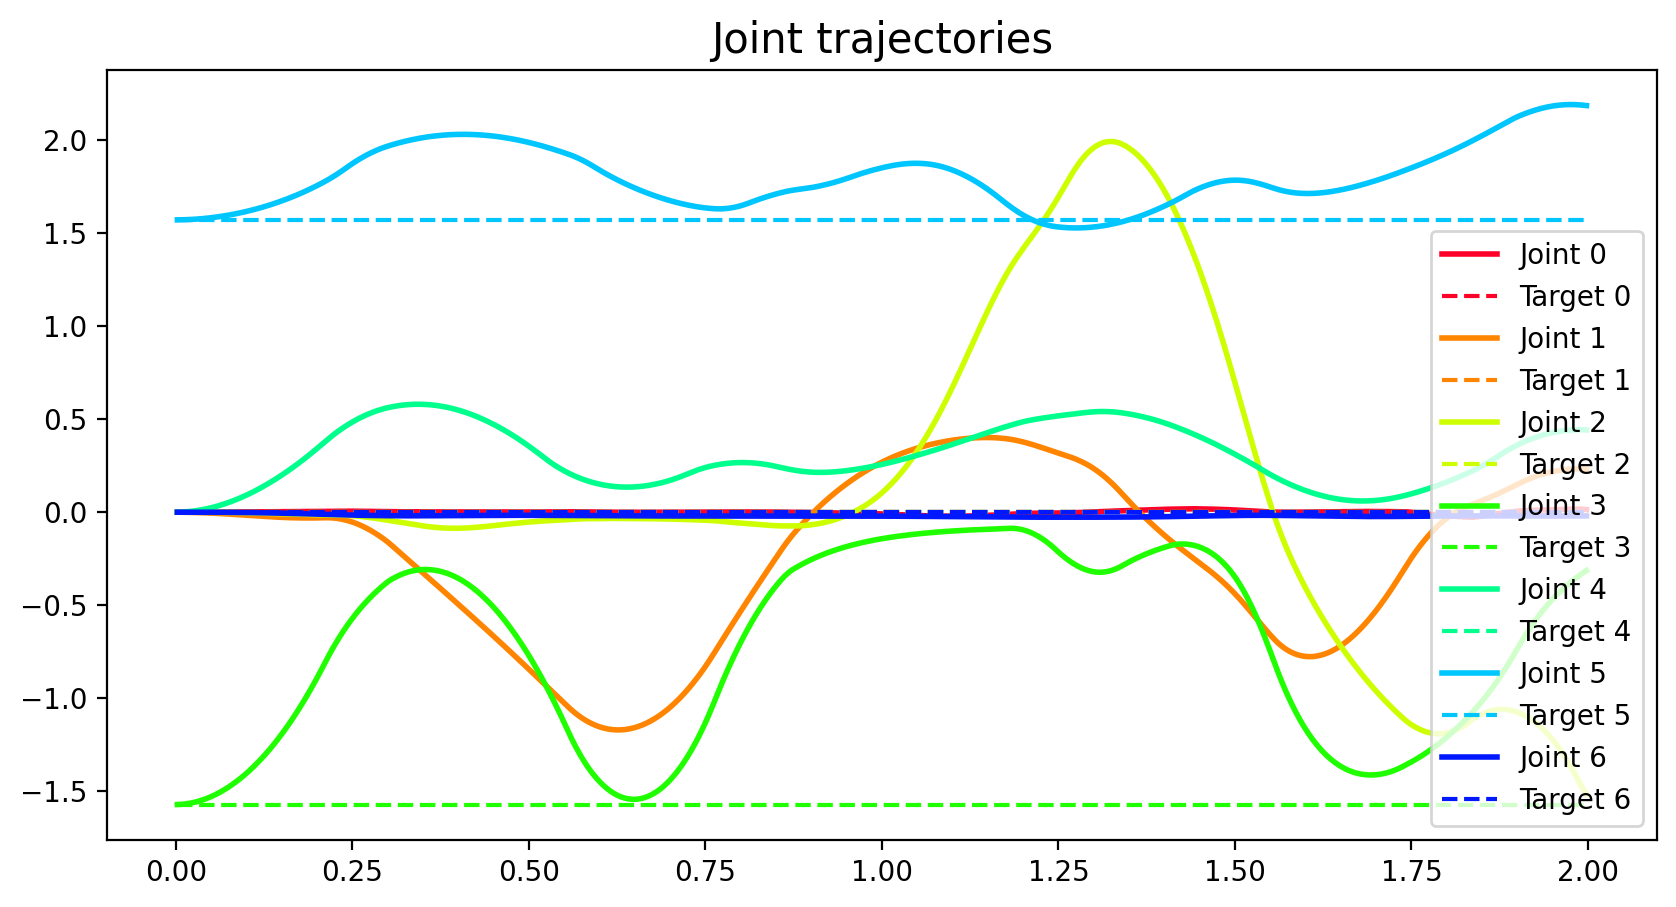

In [3]:
plt.figure(figsize=(10,5))
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,env.n_joint)])
for i_idx in range(env.n_rev_joint):
    plt.plot(sec_list[1:],q_list[1:,i_idx],'-',color=colors[i_idx],lw=2,label='Joint %d'%(i_idx))
    plt.plot(sec_list[1:],q_rev_des[i_idx]+0.0*q_list[1:,i_idx],'--',color=colors[i_idx],
             label='Target %d'%(i_idx))
plt.legend(loc='lower right')
plt.title('Joint trajectories',fontsize=15)
plt.show()